<a href="https://colab.research.google.com/github/SergioTorres-97/Lectura-basica-de-archivos-de-WEB-PORTAL-IDEAM/blob/main/Lectura_b%C3%A1sica_de_archivos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**LECTURA BÁSICA DE ARCHIVOS DE PRECIPITACIÓN GENERADOS POR EL IDEAM**

**Autor: SERGIO DAVID TORRES PIRAQUIVE**

**Descripción:**
Este script realiza la apertura de los archivos generados a través del aplicativo WEB PORTAL-IDEAM, y genera estadísticos descriptivos y salidas gráficas para el análisis preliminar de la información.

In [1]:
#Se importan las librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import os

In [2]:
#Se generan las funciones necesarias para el código
def AbrirArchivosDHIME(rutaArchivo):
    datos = pd.read_csv(rutaArchivo,index_col='Fecha')[['Valor']]
    datos.index = pd.to_datetime(datos.index)
    return datos

def AbrirArchivosWebPortal(ruta):
  datos = pd.read_csv(ruta,usecols=[0,1])
  datos.columns = datos.iloc[0]
  datos = datos.replace(',', '.', regex=True)
  datos = datos[1:].reset_index(drop=True)
  datos.columns = ['Fecha','Valor']
  datos.set_index('Fecha',inplace=True)
  datos.index = pd.to_datetime(datos.index)
  datos.Valor = datos.Valor.astype(float)
  return datos

def filtrarDatos(datos,año_inicial,año_final):
    datos = datos.loc[año_inicial:año_final]
    return datos

def identificarNAN(datos):
    fecha_inicio = datos.index[0]
    fecha_fin = datos.index[datos.shape[0]-1]
    rango_fechas = pd.date_range(start=fecha_inicio, end=fecha_fin)
    df = pd.DataFrame(rango_fechas, columns=['Fecha'])
    df.set_index('Fecha',inplace = True)

    df_fin = df.join(datos)
    return df_fin

def PromediosMensualesIDEAM(datos, numDatos, estadistico, rutaGuardado,variable,estacion):
    datos.columns = ['Valor']

    datos.index = pd.to_datetime(datos.index)

    datos = datos.resample('ME').agg([estadistico, 'count'])
    datos[estadistico] = np.where(datos['Valor']['count'] > numDatos, datos['Valor'][estadistico], np.nan)
    datos = datos[[estadistico]]
    datos.columns = ['Valor']

    datos['Mes'] = datos.index.month
    datos['Año'] = datos.index.year

    tabla = pd.pivot(datos, index='Mes', columns='Año', values='Valor')
    est_filaMean, est_filaMed, est_filaMin, est_filaMax, est_filaSum, est_filaQ25, est_fila50, est_fila75 = tabla.mean(), tabla.median(), tabla.min(), tabla.max(),tabla.sum(),tabla.quantile(0.25), tabla.quantile(0.5), tabla.quantile(0.75)

    tabla.loc['Promedio'] = est_filaMean
    tabla.loc['Mediana'] = est_filaMed
    tabla.loc['Mínimo'] = est_filaMin
    tabla.loc['Máxima'] = est_filaMax
    tabla.loc['Suma'] = est_filaSum
    tabla.loc['Q25'] = est_filaQ25
    tabla.loc['Q50'] = est_fila50
    tabla.loc['Q75'] = est_fila75


    est_colMean,est_colMed, est_colMin, est_colMax, est_Q25,est_Q50,estQ75 = tabla.mean(axis = 1),tabla.median(axis = 1), tabla.min(axis = 1), tabla.max(axis = 1),tabla.quantile(0.25,axis = 1),tabla.quantile(0.5,axis = 1),tabla.quantile(0.75,axis = 1)

    tabla['Promedio'] = est_colMean
    tabla['Mediana'] = est_colMed
    tabla['Mínimo'] = est_colMin
    tabla['Máxima'] = est_colMax
    tabla['Q25'] = est_Q25
    tabla['Q50'] = est_Q50
    tabla['Q75'] = estQ75
    tabla = tabla.round(2)

    tabla.to_excel(rutaGuardado + f'/Estadísticos mensuales {variable} - {estacion}.xlsx')
    return datos

def BoxplotMensual(datos,ylab,rutaGuardado,NombreGrafico,estacion, showfliers = True, titulo = True):
    df = datos.copy()
    df['Mes'] = datos.index.month
    plt.figure(figsize=(15,6))
    if titulo == True:
      plt.title(f'Estación {estacion}', fontsize=12, fontweight='bold')
    if showfliers == True:
        sbn.boxplot(x = 'Mes', y = df.columns[0], data = df, palette = 'seismic',zorder = 2)
    else:
        sbn.boxplot(x='Mes', y=df.columns[0], data=df, palette='seismic',showfliers = False, zorder=2)
    plt.xlabel('Mes', fontsize=12, fontweight='bold')
    plt.ylabel(ylab, fontsize=12, fontweight='bold')
    plt.rcParams['axes.axisbelow'] = True
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth='0.5',zorder = 1)
    plt.grid(which='minor', linestyle=':', linewidth='0.5',zorder = 1)
    plt.savefig(rutaGuardado + '/' + NombreGrafico + '.png', bbox_inches="tight")

In [3]:
#Datos generales de la estación
rutaGuardado = f'/content/Resultados'
variable = 'Precipitación'
estacion = 'UPTC'

In [4]:
#Crear carpeta de resultados
os.makedirs(rutaGuardado, exist_ok=True)

In [5]:
#Se establece el rango del filtro
Fecha_inicio,Fecha_fin = '1991','2020'

In [6]:
#Se abren los datos
datos = AbrirArchivosWebPortal('/content/PTPM_CON.csv')
datos = filtrarDatos(datos,Fecha_inicio,Fecha_fin)
datos = identificarNAN(datos)
datos.head(5)

,Valor
Fecha,
1991-01-01 07:00:00,0.0
1991-01-02 07:00:00,0.1
1991-01-03 07:00:00,0.0
1991-01-04 07:00:00,0.0
1991-01-05 07:00:00,0.0


In [7]:
#Se exportan las estadísticas a nivel mensual
PromediosMensuales = PromediosMensualesIDEAM(datos, 20, 'sum', rutaGuardado,variable,estacion)

<ipython-input-2-876e6f1e23cc>:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sbn.boxplot(x = 'Mes', y = df.columns[0], data = df, palette = 'seismic',zorder = 2)


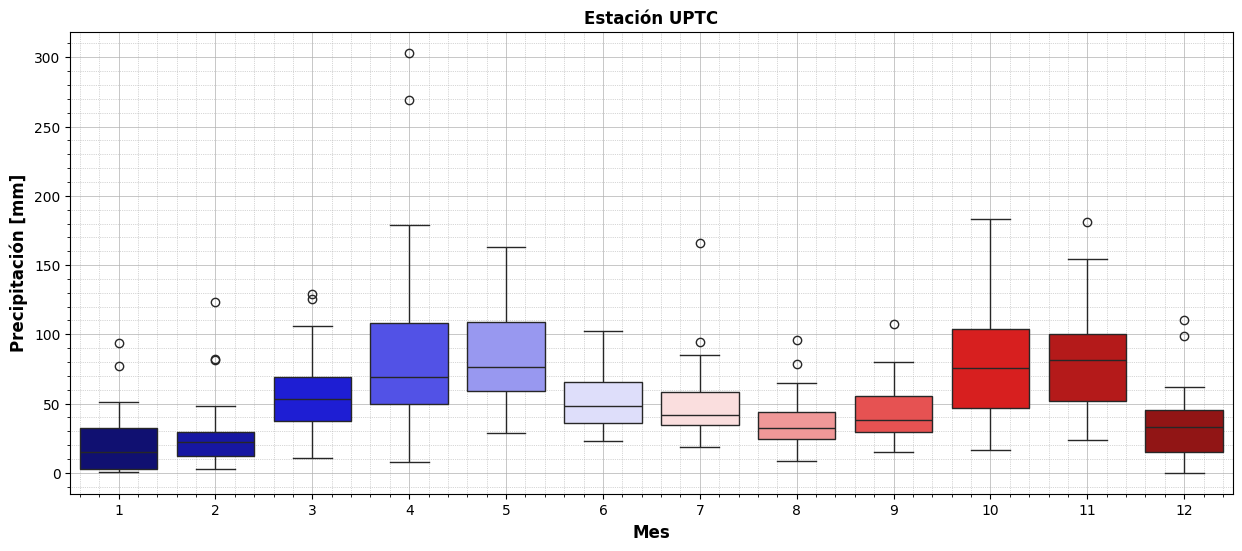

In [8]:
#Se genera el boxplot a escala mensual
BoxplotMensual(PromediosMensuales[['Valor']],f'{variable} [mm]',rutaGuardado,'Boxplot mensual',
               estacion, showfliers = True, titulo = True)

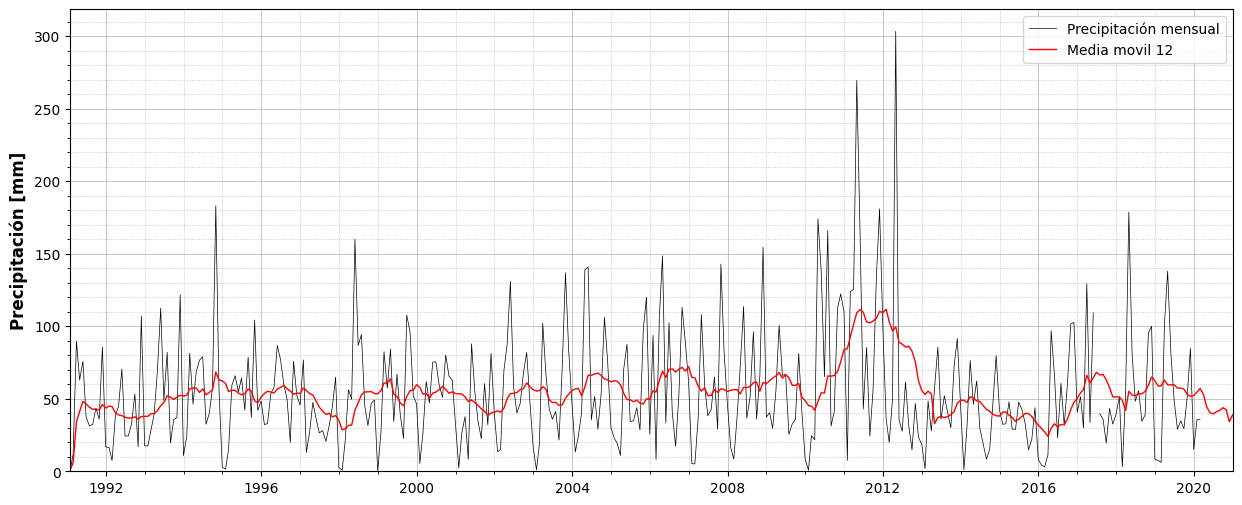

In [9]:
#Gráfica mensual
PromediosMensualesMM = PromediosMensuales.copy()

PromediosMensualesMM[f'Valor_mm'] = PromediosMensualesMM['Valor'].rolling(window=12, min_periods=1).mean()

plt.figure(figsize=(15,6))
plt.plot(PromediosMensualesMM.index,PromediosMensualesMM['Valor'],
         color = 'black',linewidth = 0.5, label = 'Precipitación mensual')
plt.plot(PromediosMensualesMM.index,PromediosMensualesMM['Valor_mm'],
         color = 'red',linewidth = 1, label = 'Media movil 12')
plt.ylabel('Precipitación [mm]', fontsize=12, fontweight='bold')
plt.xlim(PromediosMensualesMM.index[0],PromediosMensualesMM.index[-1])
plt.ylim(0)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5',zorder = 1)
plt.grid(which='minor', linestyle=':', linewidth='0.5',zorder = 1)
plt.legend()
plt.savefig(rutaGuardado + '/PromediosMensualesMM.png', bbox_inches="tight")
PromediosMensualesMM[['Valor']].to_excel(rutaGuardado + '/PromediosMensuales.xlsx')

<ipython-input-10-72c4bf63911d>:2: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  MaximosAnuales = datos.resample('A').max()
<ipython-input-10-72c4bf63911d>:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


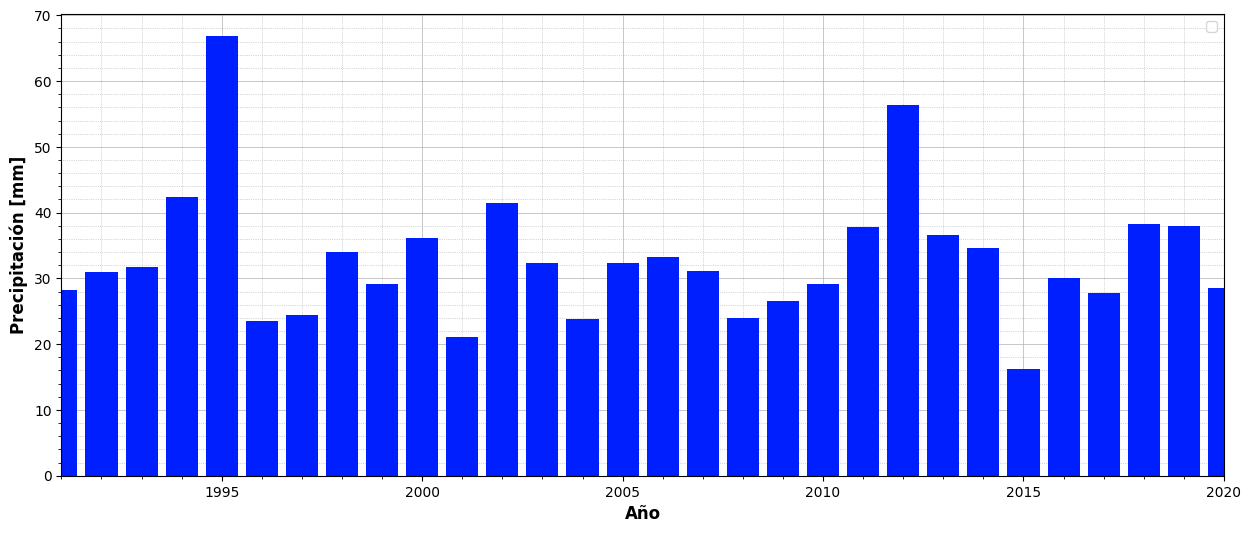

In [10]:
#Se genera la gráfica y la tabla de datos máximos anuales
MaximosAnuales = datos.resample('A').max()

plt.figure(figsize=(15, 6))
plt.bar(MaximosAnuales.index.year, MaximosAnuales['Valor'],color = '#001fff')

plt.xlim(MaximosAnuales.index.year[0],MaximosAnuales.index.year[-1])
plt.ylim(0)

plt.xlabel('Año', fontsize=12, fontweight='bold')
plt.ylabel('Precipitación [mm]', fontsize=12, fontweight='bold')

plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5',zorder = 1)
plt.grid(which='minor', linestyle=':', linewidth='0.5',zorder = 1)
plt.legend()
plt.savefig(rutaGuardado + '/MaximosAnuales.png', bbox_inches="tight")
MaximosAnuales.to_excel(rutaGuardado + '/MaximosAnuales.xlsx')

In [11]:
!zip -r Resultados.zip /content/Resultados

  adding: content/Resultados/ (stored 0%)
  adding: content/Resultados/PromediosMensuales.xlsx (deflated 6%)
  adding: content/Resultados/MaximosAnuales.png (deflated 39%)
  adding: content/Resultados/PromediosMensualesMM.png (deflated 13%)
  adding: content/Resultados/Boxplot mensual.png (deflated 36%)
  adding: content/Resultados/MaximosAnuales.xlsx (deflated 10%)
  adding: content/Resultados/Estadísticos mensuales Precipitación - UPTC.xlsx (deflated 6%)
